In [18]:
from langgraph.graph import StateGraph, START, END
from langchain_openai import ChatOpenAI
from typing import TypedDict, Annotated, Literal
from dotenv import load_dotenv
from langchain_core.messages import SystemMessage, HumanMessage
from pydantic import BaseModel, Field
import operator

In [19]:
generator_llm = ChatOpenAI(model = 'gpt-4o-mini') # use the model best suitable for genartion
evaluator_llm = ChatOpenAI(model = 'gpt-4o-mini')  # use the model best suitable for evaluation
optimizer_llm = ChatOpenAI(model = 'gpt-4o-mini') # use the model best suitable for optimization

In [20]:
# state
class TweetState(TypedDict):
    topic: str
    tweet: str
    evaluation: Literal["approved","needs_improvement"]
    feedback: str
    iterations: int
    max_iterations: int

    tweets_history: Annotated[list[str], operator.add]
    feedbacks_history: Annotated[list[str], operator.add]

In [21]:
#tweeter evaluation schema (structured output on evaluation returns only evaluation and feedback)
class TweetEvaluation(BaseModel):
    evaluation: Literal["approved","needs_improvement"] = Field(..., description='Final evaluation result')
    feedback: str = Field(..., description='Constructive feedback for the tweet')

In [22]:
structured_evaluator_llm = evaluator_llm.with_structured_output(TweetEvaluation)

In [23]:
def generate_tweet(state:TweetState):
    # prompt
    messages = [

SystemMessage(content="You are a funny and clever Twitter/X influencer."),

HumanMessage(content=f"""

Write a short, original, and hilarious tweet on the topic: "{state['topic']}",

Rules:
- Do NOT use question-answer format.
- Max 280 characters.
- Use observational humor, irony, sarcasm, or cultural references.
- Think in meme logic, punchlines, or relatable takes.
- Use simple, day to day english

""")
    ]
    # send prompt to generator llm 

    response = generator_llm.invoke(messages)
    # return response
    return {'tweet' : response, 'tweets_history': [response] }



def evaluate_tweet(state:TweetState):
    # prompt (evaluation criteria and generated tweet)
    messages = [

SystemMessage(content="You are a ruthless, no-laugh-given Twitter critic. You evaluate tweets based on hutor, originality, virality, and tweet format."),

HumanMessage(content=f"""

Evaluate the following tweet:

Tweet: "{state['tweet']}"

Use the criteria below to evaluate the tweet:

1. Originality Is this fresh, or have you seen it a hundred times before?

2. Humor Did it genuinely make you smile, laugh, or chuckle?

3. Punchiness Is it short, sharp, and scroll-stopping?

4. Virality Potential Would people retweet or share it?

5. Format Is it a well-formed tweet (not a setup-punchline joke, not a Q&A joke, and under 280 characters)?

Auto-reject if:

It's written in question-answer format (e.g., "Why did..." or "what happens when...")

It exceeds 280 characters

It reads like a traditional setup-punchline joke

Dont end with generic, throwaway, or deflating lines that weaken the humor (e.g., "Masterpieces of the auntie-uncle universe" or vague summaries)

### Respond ONLY in structured format:

evaluation: "approved" or "needs_improvement"

feedback: One paragraph explaining the strengths and weaknesses
""")
]
    # sent prompt to evaluator llm
    response = structured_evaluator_llm.invoke(messages)
    # return evaluation resulta nd feedback
    return {'evaluation':response.evaluation,'feedback': response.feedback , 'feedbacks_history': [response.feedback]}


def optimize_tweet(state:TweetState):  
    # prompt (tweet+feedback)
    messages = [

SystemMessage(content="You punch up tweets for virality and humor based on given feedback."),

HumanMessage(content=f"""

Improve the tweet based on this feedback:

"{state['feedback']}"

Topic: "{state['topic']}"

Original Tweet:

{state['tweet']}

Re-write it as a short, viral-worthy tweet. Avoid Q&A style and stay under 280 characters.
""")
]
    # send prompt to optimzer llm 
    response = optimizer_llm.invoke(messages).content
    iteration = state['iterations'] + 1
    # return optimized tweet   
    return {'tweet': response, 'iterations':iteration , 'tweets_history': [response]}

In [24]:
def checkEvaluation(state:TweetState):
    if state["evaluation"] == "approved" or state["iterations"] >= state["max_iterations"]:
        return "approved"
    else:
        return "needs_improvement"

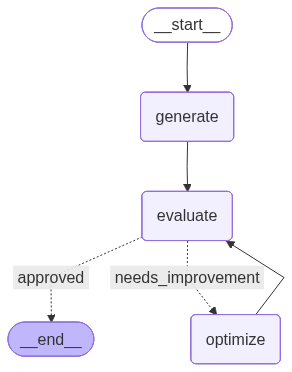

In [25]:
# define graph
graph = StateGraph(TweetState)

# add nodes
graph.add_node('generate',generate_tweet)
graph.add_node('evaluate',evaluate_tweet)
graph.add_node('optimize',optimize_tweet)


# add edges
graph.add_edge(START,'generate')
graph.add_edge('generate','evaluate')
graph.add_conditional_edges('evaluate',checkEvaluation, {'approved':END, 'needs_improvement':'optimize'})
graph.add_edge('optimize','evaluate')

# compile graph
workflow =  graph.compile()
workflow




In [14]:
# execute graph

initiate_state = {
    'topic' : "Pakistani Railways",
    'iterations': 1,
    'max_iterations':5
}

workflow.invoke(initiate_state)

RateLimitError: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}